In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
 from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [4]:
X_train = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/XDawn/X.npy")
X_test = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/XDawn/X_test.npy")
Y_train = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/XDawn/Y.npy")
Y_test = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/XDawn/Y_test.npy")
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((5670, 528), (3780, 528), (5670,), (3780,))

In [5]:
!git clone https://github.com/h2oai/pystacknet
%cd pystacknet
# %cd ..
!python setup.py install

Cloning into 'pystacknet'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), done.
/content/pystacknet
running install
running bdist_egg
running egg_info
creating pystacknet.egg-info
writing pystacknet.egg-info/PKG-INFO
writing dependency_links to pystacknet.egg-info/dependency_links.txt
writing requirements to pystacknet.egg-info/requires.txt
writing top-level names to pystacknet.egg-info/top_level.txt
writing manifest file 'pystacknet.egg-info/SOURCES.txt'
adding license file 'LICENSE.txt'
writing manifest file 'pystacknet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pystacknet
copying pystacknet/__init__.py -> build/lib/pystacknet
copying pystacknet/metrics.py -> build/lib/pystacknet
copying pystacknet/pystacknet.py -> build/lib/pystacknet
creating build/lib/pystacknet/test
co

In [6]:
!pip install LightGBM
!pip install XGBoost

In [9]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from pystacknet.pystacknet import StackNetClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [68]:

models = [
    #1ST layer #
    [GridSearchCV(LDA(solver='lsqr'),  {'shrinkage': (0.01, 0.1, 1.)}, cv=3, n_jobs=-1),
     GridSearchCV(SVC(class_weight='balanced', probability=True),  {'kernel': [
                  'rbf'], 'gamma': [10**(-2), 10**(-3)], 'C': [100, 10, 1, 0.1]}, cv=3, n_jobs=-1),
     GridSearchCV(LogisticRegression(class_weight='balanced',
                                     solver='lbfgs', max_iter=100000), {'C': [100, 10, 1, 0.1]}, cv=3, n_jobs=-1),
     LGBMClassifier(boosting_type='gbdt', num_leaves=40, max_depth=-1, learning_rate=0.01, n_estimators=1000, class_weight='balanced', subsample_for_bin=1000, objective="xentropy",
                    min_split_gain=0.0, min_child_weight=0.01, min_child_samples=10, subsample=0.9, subsample_freq=1, colsample_bytree=0.5, reg_alpha=0.0, reg_lambda=0.0, random_state=1, n_jobs=1),
     GaussianProcessClassifier(),
    #  XGBClassifier(max_depth=5, learning_rate=0.3, reg_lambda=0.1, n_estimators=300,
    #                objective="binary:logistic", n_jobs=1, booster="gblinear", random_state=1, colsample_bytree=0.4),
    #  XGBClassifier(max_depth=20, learning_rate=0.1, n_estimators=300, objective="binary:logistic",
    #                n_jobs=1, booster="gbtree", random_state=1, colsample_bytree=0.4),
    #  XGBClassifier(max_depth=100, learning_rate=0.1, n_estimators=300, objective="rank:pairwise",
    #                n_jobs=1, booster="gbtree", random_state=1, colsample_bytree=0.4),
     ],

    #2ND layer #
    [
        RandomForestClassifier(max_depth=50, n_estimators=50),
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
            max_depth=5), n_estimators=200),
        ExtraTreesClassifier(max_depth=5, n_estimators=50),
    ],

    #3RD layer #
    [
        RandomForestClassifier(
            max_depth=5, class_weight='balanced', n_estimators=100),
        SVC(kernel='linear', class_weight='balanced', probability=True),
        # MLPClassifier(hidden_layer_sizes=(32, 16), activation="relu", solver="sgd", alpha=0.01,
        #               batch_size=30, learning_rate="adaptive", learning_rate_init=0.001, power_t=0.5,
        #               max_iter=100, shuffle=True, random_state=1, tol=0.0001, nesterovs_momentum=True, momentum=0.9, validation_fraction=0.1, early_stopping=True,
        #               beta_1=0.1, beta_2=0.1, epsilon=0.1)
    ]
]

In [11]:
# leave 4 subject out
kf = KFold(4)
generator = kf.split(X_train, Y_train)

# build StackNet
stacknet = StackNetClassifier(models, metric="auc", folds=generator, 
           restacking=False, use_retraining=True, use_proba=True,
           n_jobs=-1, verbose=1)

In [70]:
from pystacknet.pystacknet import StackNetClassifier

model=StackNetClassifier(models, metric="f1", folds=2,
	restacking=False,use_retraining=True, use_proba=True, 
	random_state=12345,n_jobs=-1, verbose=1)

model.fit(X_train,Y_train)
preds=model.predict_proba(X_test)

====================== Start of Level 0 ======================
Input Dimensionality 528 at Level 0 
5 models included in Level 0 
Level 0, fold 1/2 , model 0 , f1===0.833067 
Level 0, fold 1/2 , model 1 , f1===0.962197 
Level 0, fold 1/2 , model 2 , f1===0.843364 
Level 0, fold 1/2 , model 3 , f1===0.957109 
Level 0, fold 1/2 , model 4 , f1===0.925338 
=========== end of fold 1 in level 0 ===========
Level 0, fold 2/2 , model 0 , f1===0.840568 
Level 0, fold 2/2 , model 1 , f1===0.961524 
Level 0, fold 2/2 , model 2 , f1===0.852547 
Level 0, fold 2/2 , model 3 , f1===0.960311 
Level 0, fold 2/2 , model 4 , f1===0.928110 
=========== end of fold 2 in level 0 ===========
Level 0, model 0 , f1===0.836818 
Level 0, model 1 , f1===0.961860 
Level 0, model 2 , f1===0.847956 
Level 0, model 3 , f1===0.958710 
Level 0, model 4 , f1===0.926724 
Output dimensionality of level 0 is 5 
====================== End of Level 0 ======================
 level 0 lasted 1373.220772 seconds 
===============

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Level 1, fold 1/2 , model 0 , f1===0.973792 
Level 1, fold 1/2 , model 1 , f1===0.972862 
Level 1, fold 1/2 , model 2 , f1===0.973328 
=========== end of fold 1 in level 1 ===========
Level 1, fold 2/2 , model 0 , f1===0.976115 
Level 1, fold 2/2 , model 1 , f1===0.975140 
Level 1, fold 2/2 , model 2 , f1===0.980922 
=========== end of fold 2 in level 1 ===========
Level 1, model 0 , f1===0.974953 
Level 1, model 1 , f1===0.974001 
Level 1, model 2 , f1===0.977125 
Output dimensionality of level 1 is 3 
====================== End of Level 1 ======================
 level 1 lasted 9.637156 seconds 
====================== Start of Level 2 ======================
Input Dimensionality 3 at Level 2 
2 models included in Level 2 
Level 2, fold 1/2 , model 0 , f1===0.970370 
Level 2, fold 1/2 , model 1 , f1===0.972462 
=========== end of fold 1 in level 2 ===========
Level 2, fold 2/2 , model 0 , f1===0.974950 
Level 2, fold 2/2 , model 1 , f1===0.978977 
=========== end of fold 2 in level 2 ==

In [63]:
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_train = model.predict_proba(X_train)[:, 1]
y_pred_val = model.predict_proba(ALS_X)[:, 1]

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 
====================== Start of Level 2 ======================
1 estimators included in Level 2 
====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 
====================== Start of Level 2 ======================
1 estimators included in Level 2 
====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 
====================== Start of Level 2 ======================
1 estimators included in Level 2 


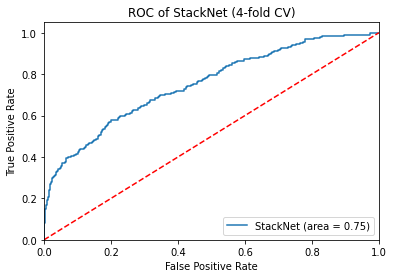

In [64]:

r_roc_auc = roc_auc_score(Y_test, y_probs)
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='StackNet (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of StackNet (4-fold CV)')
plt.legend(loc="lower right")
# plt.savefig('images2/StackNet_ROC')
plt.show()

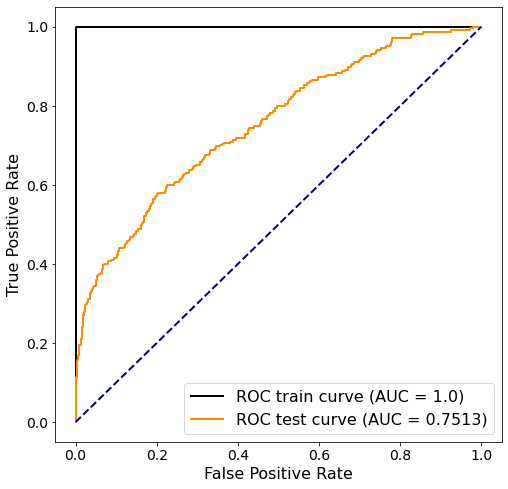

In [65]:
fpr_train, tpr_train, _ = roc_curve(Y_train, y_pred_train, pos_label=1)
fpr_test, tpr_test, _ = roc_curve(Y_test, y_probs, pos_label=1)
fpr_val, tpr_val, _ = roc_curve(ALS_Y, y_pred_val, pos_label=2)
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='black',
          lw=2,label=f"ROC train curve (AUC = {round(roc_auc_score(Y_train, y_pred_train), 4)})")
plt.plot(fpr_test, tpr_test, color='darkorange',
          lw=2,label=f"ROC test curve (AUC = {round(roc_auc_score(Y_test, y_probs), 4)})")
# plt.plot(fpr_val, tpr_val, color='red',
#           lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(f'ROC Plot for {model_name}', weight="bold", fontsize=20)
plt.legend(loc="lower right", fontsize=16)

In [66]:
y_pred.mean(axis=1)

array([0.83132275, 0.12376779, 0.12942339, ..., 0.16079695, 0.16822145,
       0.12195652])

In [67]:
y_probs.shape

(3780,)